# Sampling 3DEP Example

# Purpose

# Demonstrate how to sample the 3DEP 1m DEMs at GEDI L4A footprints

In [1]:
import time
import matplotlib.pyplot as plt
from sliderule import gedi, earthdata, raster
import sliderule


from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# Initialize client

In [2]:
gedi.init("slideruleearth.io", verbose=True)

# Specify region of interest from geojson

In [3]:
## Region 1: South Cascade Glacier
## Upper left (lon/lat): -121.0742643433662, 48.37159557493268
## Lower right (lon/lat): -121.03683181392472, 48.341195823749906

# lon_up = -121.0742643433662
# lat_up =  48.37159557493268
# lon_lo = -121.03683181392472
# lat_lo =  48.341195823749906
# region_name='South Cascade Glacier'

## Region 2: Maryland
## Upper left (lon/lat): -77.41454197206069, 39.290044188370636
## Lower right (lon/lat): -77.39562385238138, 39.239373031026304

lon_up = -77.41454197206069
lat_up =  39.290044188370636
lon_lo = -77.39562385238138
lat_lo =  39.239373031026304
region_name='Maryland'


In [4]:
# Configure Region of Interest
region = [ {"lon":lon_up, "lat": lat_up},
           {"lon":lon_lo, "lat": lat_up},
           {"lon":lon_lo, "lat": lat_lo},
           {"lon":lon_up, "lat": lat_lo},
           {"lon":lon_up, "lat": lat_up} ]


# poly_fn = 'grandmesa.geojson'
# region = sliderule.toregion(poly_fn)

# Query USGS "The National Map" API for 3DEP 1m products in area of interest

In [5]:
# geojson = earthdata.tnm(short_name='Digital Elevation Model (DEM) 1 meter', polygon=region["poly"])
geojson = earthdata.tnm(short_name='Digital Elevation Model (DEM) 1 meter', polygon=region)

# Make GEDI L4A subset request with 3DEP sampling

In [6]:
# Build GEDI L4A Request Parameters
# parms = {
#     "poly": region["poly"],
#     "degrade_flag": 0,
#     "l2_quality_flag": 1,
#     "beam": 0,
#     "samples": {"3dep": {"asset": "usgs3dep-1meter-dem", "catalog": geojson}} 
# }

parms = {
    "poly": region,
    "degrade_flag": 0,
    "l2_quality_flag": 1,
    "samples": {"3dep": {"asset": "usgs3dep-1meter-dem", "catalog": geojson}} 
}

# Latch Start Time
perf_start = time.perf_counter()

# Request GEDI Data
# gedi04a = gedi.gedi04ap(parms, resources=['GEDI04_A_2019123154305_O02202_03_T00174_02_002_02_V002.h5'])
gedi04a = gedi.gedi04ap(parms) 

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Received {} footprints".format(gedi04a.shape[0]))
if len(gedi04a) > 0:
    print("Beams: {}".format(gedi04a["beam"].unique()))

Completed in 6.810 seconds of wall-clock time
Received 1971 footprints
Beams: [ 2  3  1  0  5  6  8 11]


In [7]:
# gedi04a

## Massage DataFrame: trim NaN and no-data rows and flatten samples

In [8]:
gdf = gedi04a[gedi04a["3dep.value"].notna()]

In [9]:
def getFirstValue(x):
    if type(x["3dep.value"]) == float:
        return x['3dep.value']
    else:
        return x['3dep.value'][0]
        
gdf = gdf.copy()
gdf["3dep"] = gdf.apply(lambda x: getFirstValue(x), axis=1)

/home/jovyan/envs/basemap_py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [10]:
gdf = gdf[gdf["3dep"] > -9999.0]

## Plot elevations using coordinates

<Axes: title={'center': '3DEP'}>

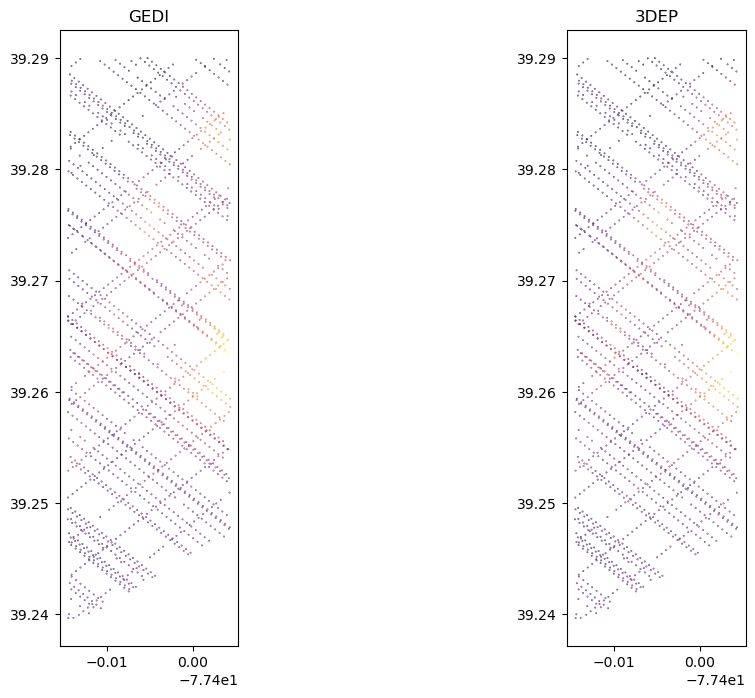

In [11]:
f, ax = plt.subplots(1, 2, figsize=[12,8])
ax[0].set_title("GEDI")
ax[0].set_aspect('equal')
gdf.plot(ax=ax[0], column='elevation', cmap='inferno', s=0.1)
ax[1].set_title("3DEP")
ax[1].set_aspect('equal')
gdf.plot(ax=ax[1], column='3dep', cmap='inferno', s=0.1)

## Plot comparison of elevations

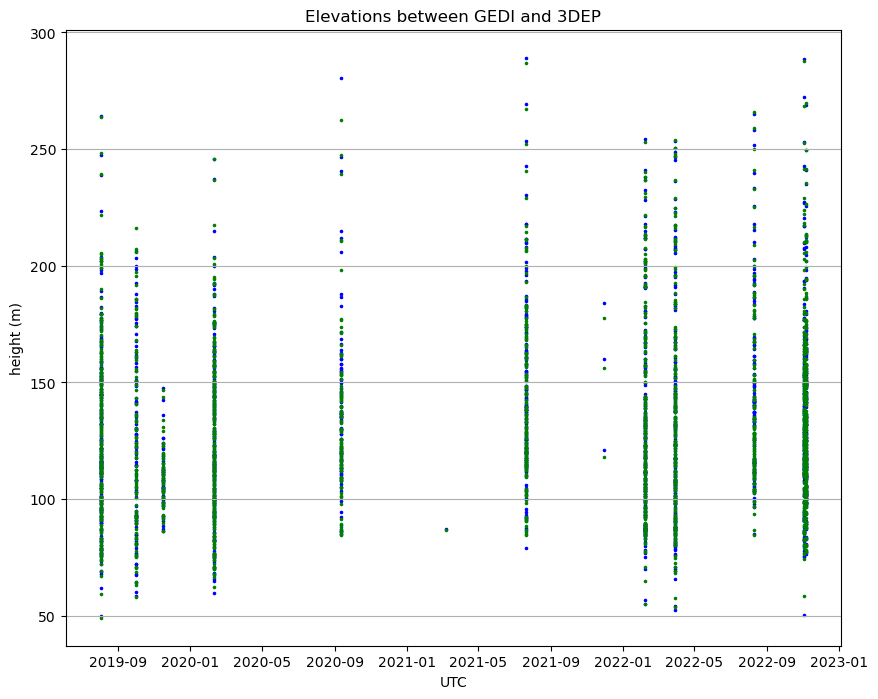

In [12]:
fig,ax = plt.subplots(num=None, figsize=(10, 8))
fig.set_facecolor('white')
fig.canvas.header_visible = False
ax.set_title("Elevations between GEDI and 3DEP")
ax.set_xlabel('UTC')
ax.set_ylabel('height (m)')
ax.yaxis.grid(True)
sc1 = ax.scatter(gdf.index.values, gdf["elevation"].values, c='blue', s=2.5)
sc2 = ax.scatter(gdf.index.values, gdf["3dep"].values, c='green', s=2.5)
plt.show()

## Plot Histogram of Differences

(array([  1.,   2.,   0.,   3.,   3.,   4.,   3.,   5.,   2.,   2.,   7.,
          5.,   7.,   1.,  10.,  10.,   5.,   7.,   6.,   9.,  10.,   7.,
         12.,  24.,  22.,  25.,  35.,  48.,  82., 115., 200., 251., 231.,
        143.,  93.,  77.,  40.,  43.,  26.,  28.,  18.,  10.,   9.,   8.,
          3.,   3.,   7.,   7.,   5.,   6.,   6.,   2.,   3.,   1.,   4.,
          4.,   4.,   4.,   2.,   3.,   1.,   4.,   8.,   5.,   4.,   2.,
          4.,   1.,   4.,   4.,   5.,   4.,   3.,   4.,   3.,   3.,   4.,
          4.,   2.,   2.,   1.,   1.,   0.,   2.,   1.,   2.,   2.,   0.,
          2.,   2.,   0.,   0.,   1.,   2.,   1.,   3.,   0.,   1.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-9.94199139e+00, -9.62171924e+00, -9.30144710e+00, -8.98117496e+00,
        -8.66090281e+00, -8.34063067e+00, -8.02035853e+00,

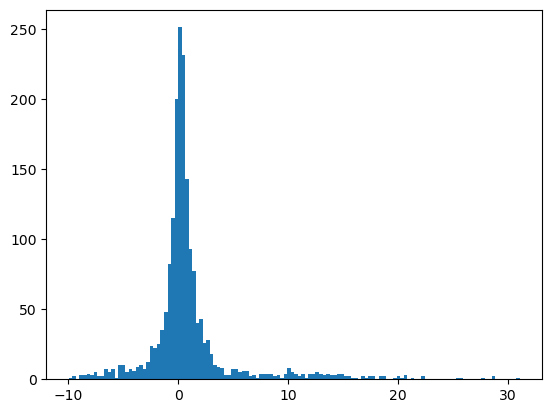

In [13]:
gdf['elev_diff'] = gdf['elevation'] - gdf['3dep']
plt.hist(gdf['elev_diff'], bins=128)
 

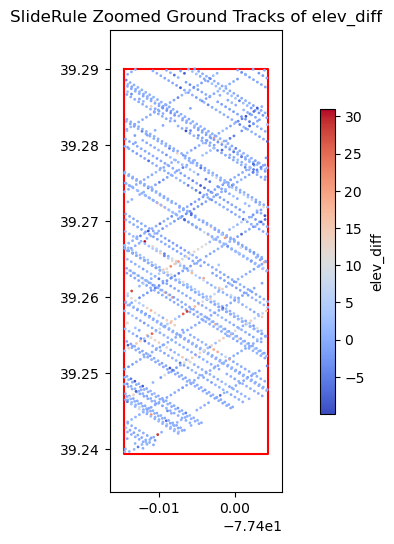

In [16]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

var_name='elev_diff'

# Calculate Extent
lons = [p["lon"] for p in region]
lats = [p["lat"] for p in region]
lon_margin = (max(lons) - min(lons)) * 0.1
lat_margin = (max(lats) - min(lats)) * 0.1

# Create Plot
fig, ax1 = plt.subplots(num=None, ncols=1, figsize=(12, 6))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1.set_title(f"SlideRule Zoomed Ground Tracks of {var_name}")    
# 1) Draw the geopandas plot:
scatter= gdf.plot(ax=ax1, column=gdf[var_name], cmap="coolwarm", s=1.0, zorder=3)  
# 2) Set axis limits and aspect:
ax1.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
ax1.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
ax1.set_aspect('equal', adjustable='box')

#3) Create and add a colorbar:    
# Create a normalization instance
norm = Normalize(vmin=gdf[var_name].min(),vmax=gdf[var_name].max())    
# Create scalar mappable based on our colormap and normalization
sm = ScalarMappable(norm=norm, cmap="coolwarm")
sm.set_array([])  # Required for fig.colorbar()   
# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=ax1,fraction=0.046,pad=0.04,shrink=0.66)
cbar.set_label(var_name)# label for the colorbar

# 4) Draw the region outline:
ax1.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)  


